In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 97% 756M/778M [00:04<00:00, 261MB/s]
100% 778M/778M [00:04<00:00, 173MB/s]


In [ ]:
! kaggle competitions download u-net-lung-segmentation-montgomery-shenzhen

404 - Not Found


In [ ]:
! unzip covid19-radiography-database.zip


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
import os
import imageio

In [ ]:
DIR = "COVID-19_Radiography_Dataset/COVID/images"

xray_image = imageio.imread(os.path.join(DIR, "COVID-1.png"))

In [ ]:
print(xray_image.shape)
print(xray_image.dtype)

(299, 299)
uint8


In [ ]:
import numpy as np
num_imgs = 10

combined_xray_images_1 = np.array(
    [imageio.imread(os.path.join(DIR, f"COVID-{i}.png")) for i in range(1,num_imgs)]
)

In [ ]:
combined_xray_images_1.shape

(9, 299, 299)

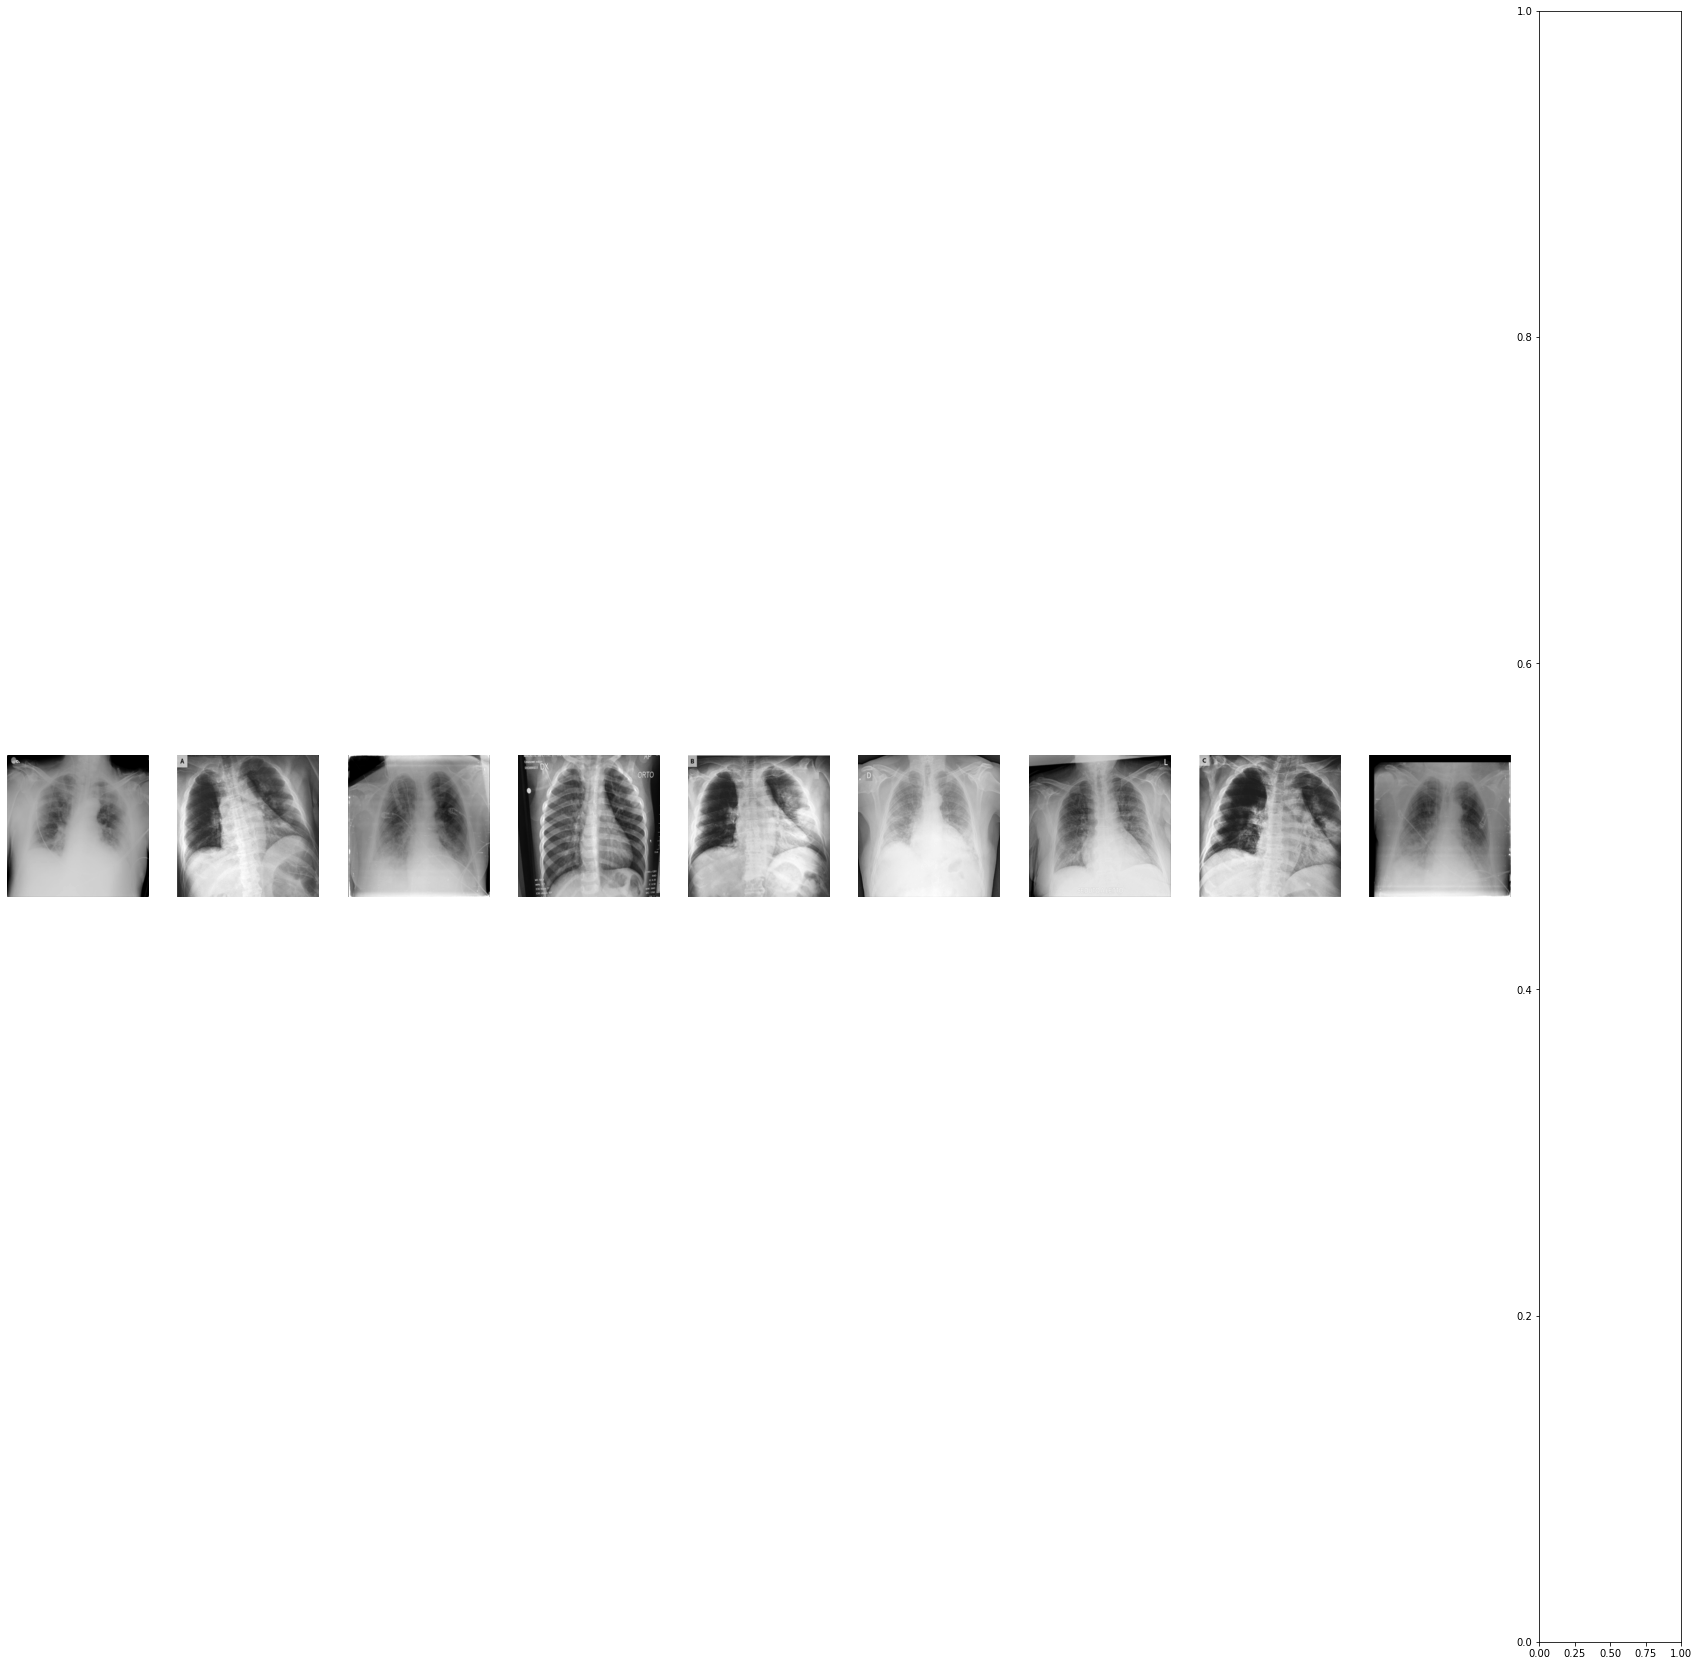

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=num_imgs, figsize=(30, 30))

for img, ax in zip(combined_xray_images_1, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

In [ ]:
from scipy import ndimage

xray_image_laplace_gaussian = ndimage.gaussian_laplace(xray_image, sigma=1)

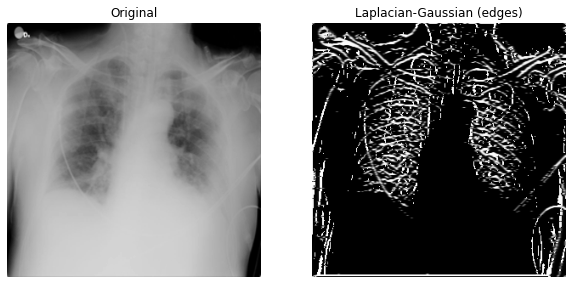

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplacian-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [ ]:
x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(xray_image, sigma=2)

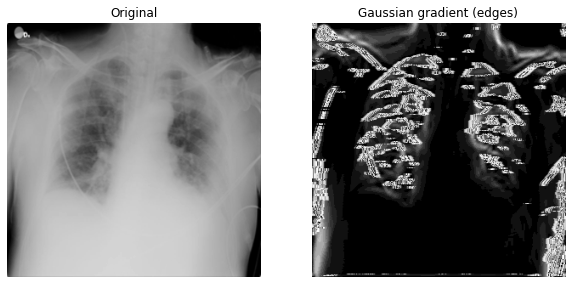

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Gaussian gradient (edges)")
axes[1].imshow(x_ray_image_gaussian_gradient, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [ ]:
fourier_gaussian = ndimage.fourier_gaussian(xray_image, sigma=0.05)

x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)

xray_image_canny = np.hypot(x_prewitt, y_prewitt)

xray_image_canny *= 255.0 / np.max(xray_image_canny)

print("The data type - ", xray_image_canny.dtype)

The data type -  float64


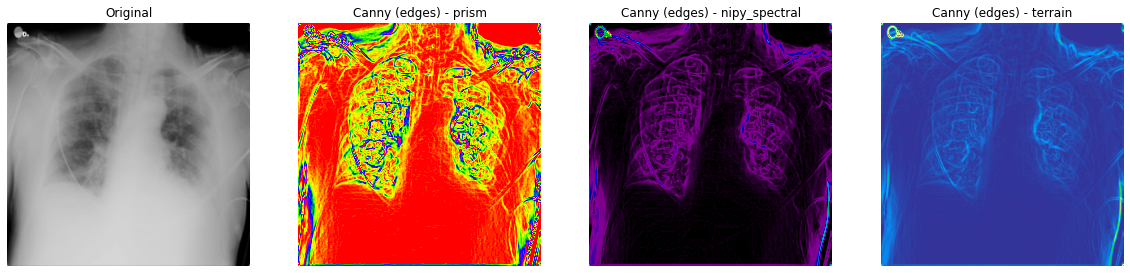

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Canny (edges) - prism")
axes[1].imshow(xray_image_canny, cmap="prism")
axes[2].set_title("Canny (edges) - nipy_spectral")
axes[2].imshow(xray_image_canny, cmap="nipy_spectral")
axes[3].set_title("Canny (edges) - terrain")
axes[3].imshow(xray_image_canny, cmap="terrain")
for i in axes:
    i.axis("off")
plt.show()

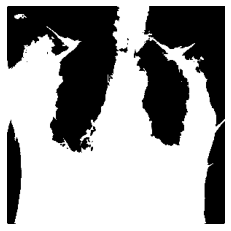

In [ ]:
xray_image_mask_noisy = np.where(xray_image > 147, 1, 0)

plt.imshow(xray_image_mask_noisy, cmap="gray")
plt.axis("off")
plt.show()

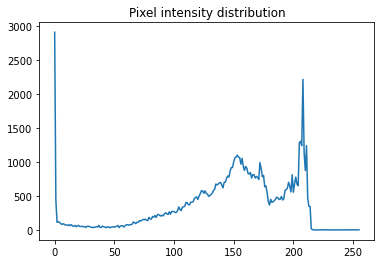

In [ ]:
pixel_intensity_distribution = ndimage.histogram(
    xray_image, min=np.min(xray_image), max=np.max(xray_image), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

In [ ]:
import torch
from torch import optim, nn
from torchvision import models, transforms
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]

  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out)
    return out

# Initialize the model
model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

In [ ]:
from tqdm import tqdm
import numpy as np
import cv2

from torchvision import transforms

from PIL import Image

# Transform the image, so it becomes readable with the model

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(448),
  transforms.ToTensor()
])
# Will contain the feature

x = []
batch = 64
train_loader = []

for i in range(100)):
    for i in range(1,10):
      path = os.path.join(os.path.join(DIR, f"COVID-{i}.png"))
      img = cv2.imread(path)
      img_trans = transform(img)
      img = img.reshape(1, 3, 448, 448)
      x.append(img)
    train_loader.append(x)
    x=[]

# Iterate each image
for i in range(1,):
	# Set the image path
  path = os.path.join(os.path.join(DIR, f"COVID-{i}.png"))
  # Read the file
  img = cv2.imread(path)
  type(img)
	# Transform the image

  # Define a transform to convert the image to tensor
  #transform = transforms.ToTensor()

  # Convert the image to PyTorch tensor

  img = transform(img)
	# Reshape the image. PyTorch model reads 4-dimensional tensor
	# [batch_size, channels, width, height]
  #print (img.shape)
  img = img.reshape(1, 3, 448, 448)
  device = 'cpu'
  img = img.to(device)
	# We only extract features, so we don't need gradient
  with torch.no_grad():
		# Extract the feature from the image
    feature = new_model(img)
	# Convert to NumPy Array, Reshape it, and save it to features variable
  features.append(feature.cpu().detach().numpy().reshape(-1))

# Convert to NumPy Array
features = np.array(features)

In [ ]:
print(features.shape)

(15, 4096)


In [ ]:
import os
!chdir("/content/data")
!mkdir train_data

/bin/bash: -c: line 0: syntax error near unexpected token `"/content/data"'
/bin/bash: -c: line 0: `chdir("/content/data")'
mkdir: cannot create directory ‘train_data’: File exists


In [ ]:
import shutil
import os
DIR = "COVID-19_Radiography_Dataset/COVID/images"
dest = "data/train_data"
for i in range(1,1000):
  path = os.path.join(os.path.join(DIR, f"COVID-{i}.png"))
  shutil.move(path, dest)


In [ ]:
DIR = "COVID-19_Radiography_Dataset/Normal/images"
dest = "data/train_data"
for i in range(1,1000):
  path = os.path.join(os.path.join(DIR, f"Normal-{i}.png"))
  shutil.move(path, dest)